In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
base_results_dir = Path(cfg.results_dirs['mutation'],
                        'batch_correction')

# which gene to plot
plot_genes = ['TP53', 'KRAS', 'EGFR', 'IDH1', 'SETD2', 'PIK3CA']

# how many features to plot, 1000 or 5000
plot_feats = 1000

In [3]:
def load_single_model(results_dir):
    results_df = pd.DataFrame()
    for results_file in results_dir.iterdir():
        if not results_file.is_file(): continue
        results_filename = str(results_file.stem)
        if results_filename[0] == '.': continue
        if ('classify' not in results_filename or 
            'metrics' not in results_filename): continue
        id_results_df = pd.read_csv(results_file, sep='\t')
        results_df = pd.concat((results_df, id_results_df))
    return results_df
    
def load_all_models(base_results_dir, genes, num_feats):
    models = ['linear', 'nonlinear', 'linear_bc', 'nonlinear_bc']
    results_df = pd.DataFrame()
    for gene in genes:
        for model in models:
            results_dir = Path(base_results_dir,
                               '{}_{}'.format(model, num_feats),
                               'gene',
                               gene)
            try:
                model_results_df = load_single_model(results_dir)
                model_results_df['model'] = model
                model_results_df['num_feats'] = num_feats
            except FileNotFoundError:
                model_results_df = pd.DataFrame()
            results_df = pd.concat((results_df, model_results_df))
    return results_df

In [4]:
results_df = load_all_models(base_results_dir, plot_genes, plot_feats)
print(results_df.shape)
results_df.head()

(1152, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,model,num_feats
0,0.75294,0.72823,TP53,expression,shuffled,42,train,0,linear,1000
1,0.73665,0.70309,TP53,expression,shuffled,42,test,0,linear,1000
2,0.62456,0.57947,TP53,expression,shuffled,42,cv,0,linear,1000
3,0.75221,0.72712,TP53,expression,shuffled,42,train,1,linear,1000
4,0.70829,0.68295,TP53,expression,shuffled,42,test,1,linear,1000


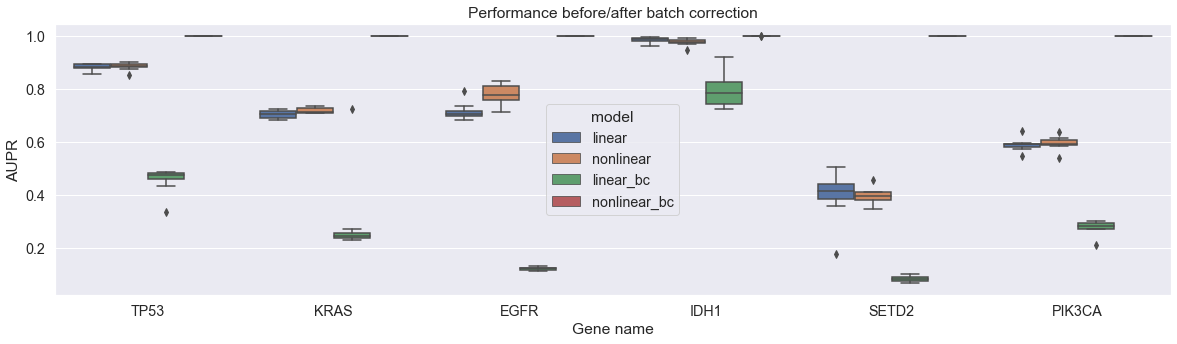

In [5]:
plot_df = results_df[
    (results_df.signal == 'signal') &
    (results_df.data_type == 'test')
]

with sns.plotting_context('notebook', font_scale=1.3):
    sns.set({'figure.figsize': (20, 5)})
    sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR')
    plt.title('Performance before/after batch correction')

In [6]:
cmp_results_df = pd.DataFrame()
for model in results_df.model.unique():
    cmp_model_results_df = au.compare_control_ind(results_df[results_df.model == model],
                                                  identifier='identifier',
                                                  metric='aupr',
                                                  verbose=True)
    cmp_model_results_df['model'] = model
    cmp_results_df = pd.concat((cmp_results_df, cmp_model_results_df))
cmp_results_df.head()

,identifier,seed,fold,delta_aupr,model
0,EGFR,42,0,0.53390,linear
1,EGFR,42,1,0.50484,linear
2,EGFR,42,2,0.62369,linear
3,EGFR,42,3,0.55159,linear
4,EGFR,1,0,0.51877,linear


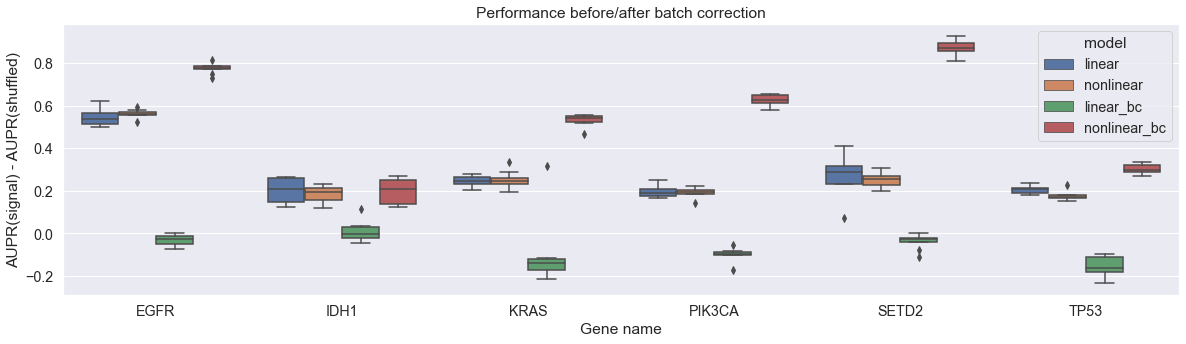

In [7]:
sns.set({'figure.figsize': (20, 5)})

with sns.plotting_context('notebook', font_scale=1.3):
    sns.boxplot(data=cmp_results_df, x='identifier', y='delta_aupr', hue='model')
    plt.xlabel('Gene name')
    plt.ylabel('AUPR(signal) - AUPR(shuffled)')
    plt.title('Performance before/after batch correction')